# Covid-19 Vaccines in California and their Impacts

## Data Cleaning and Exploration

In [1]:
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import datetime as dt
import requests
from census import Census
from us import states
import json
import time
from datetime import date
from scipy.stats import linregress
import numpy as np

#import API keys
from config import api_key
from config import gkey
c = Census(api_key)

### Cleaning Data

In [2]:
# Cleaning Cases Data
case_df = pd.read_csv("Data/covid19cases_test.csv")

# change date column to easier to compare format
case_df.date = pd.to_datetime(case_df['date'],format='%m/%d/%Y')

# filter out dates past 3-31-21, as well as rows with useless data
clean_case = case_df.loc[(case_df.date<dt.datetime(2021,4,1)) & \
                         (case_df.area != 'Out of state') & \
                         (case_df.area != 'California')& \
                         (case_df.area != 'Unknown')]

# filter out columns we dont need
clean_case = clean_case[['date','area','population','cases','deaths','total_tests','positive_tests']]

# Rename column for dataset consistency
clean_case = clean_case.rename(columns={'area': 'county'})

# replace missing data with 0
clean_case = clean_case.fillna(0)
clean_case["Cases Per 100k"] = round(clean_case["cases"] / clean_case["population"] * 100000,2)
clean_case.to_csv('Data/clean_case.csv', index=False)

clean_case.head()

,date,county,population,cases,deaths,total_tests,positive_tests,Cases Per 100k
1403,2021-03-31,Alameda,1685886.0,98.0,1.0,10553.0,123.0,5.81
1404,2021-03-31,Alpine,1117.0,0.0,0.0,3.0,0.0,0.00
1405,2021-03-31,Amador,38531.0,3.0,0.0,317.0,8.0,7.79
1406,2021-03-31,Butte,217769.0,11.0,0.0,632.0,11.0,5.05
1407,2021-03-31,Calaveras,44289.0,4.0,0.0,80.0,4.0,9.03


In [3]:
# Cleaning Vaccinations Data
vaccine_df = pd.read_csv("Data/covid19vaccinesbycounty.csv")
vaccine_df.head()

# Dropping unneeded columns
vaccine_df=vaccine_df.drop(columns=['cumulative_pfizer_doses',
                         'cumulative_moderna_doses','cumulative_jj_doses',
                         'cumulative_at_least_one_dose', 'california_flag'])
vaccine_df=vaccine_df.drop(vaccine_df[(vaccine_df['county']=='All CA Counties')|
                                      (vaccine_df['county']=='All CA and Non-CA Counties')|
                                      (vaccine_df['county']=='Outside California')|
                                      (vaccine_df['county']=='Unknown')].index)

vaccine_df.to_csv('Data/vaccine_df.csv', index=False)

vaccine_df.head()

,county,administered_date,total_doses,cumulative_total_doses,pfizer_doses,moderna_doses,jj_doses,partially_vaccinated,total_partially_vaccinated,fully_vaccinated,cumulative_fully_vaccinated,at_least_one_dose
511,Alameda,12/15/2020,36,36,36,0,0,36,36,0,0,36
512,Alameda,12/16/2020,202,238,202,0,0,202,238,0,0,202
513,Alameda,12/17/2020,396,634,396,0,0,396,634,0,0,396
514,Alameda,12/18/2020,1766,2400,1765,1,0,1766,2400,0,0,1766
515,Alameda,12/19/2020,1357,3757,1357,0,0,1357,3757,0,0,1357


In [4]:
# Cleaning Hospital Data

file = "Data/covid19hospitalbycounty.csv"
Hospitalization_data = pd.read_csv(file)
Hospitalization_data.drop(columns=['icu_suspected_covid_patients',
                                  'hospitalized_covid_confirmed_patients'])
Hospitalization_data['todays_date']=pd.to_datetime(Hospitalization_data['todays_date'])

#Rename Columns
Hospitalization_Cleaned = Hospitalization_data.rename(columns={'todays_date':'Date',
                                                           'county':'County',
                                                           'hospitalized_covid_confirmed_patients':'Confirmed Covid Cases',
                                                           'all_hospital_beds': 'All Hospital Beds',
                                                           'icu_covid_confirmed_patients': 'ICU Confirmed Cases',
                                                           'hospitalized_covid_patients': 'Hospitalized Patients',
                                                           'hospitalized_suspected_covid_patients':'Suspected Covid Cases',
                                                           'icu_suspected_covid_patients':'ICU Suspected Cases',
                                                           'icu_available_beds':'ICU Available Beds'})
Hospitalization_data.head()


,county,todays_date,hospitalized_covid_confirmed_patients,hospitalized_suspected_covid_patients,hospitalized_covid_patients,all_hospital_beds,icu_covid_confirmed_patients,icu_suspected_covid_patients,icu_available_beds
0,Ventura,2020-03-29,24.0,85.0,NaN,NaN,5.0,19.0,14.0
1,Madera,2020-03-29,1.0,6.0,NaN,NaN,1.0,1.0,8.0
2,Santa Cruz,2020-03-29,0.0,0.0,NaN,NaN,0.0,0.0,NaN
3,Yolo,2020-03-29,2.0,3.0,NaN,NaN,1.0,1.0,0.0
4,San Diego,2020-03-29,121.0,211.0,NaN,NaN,77.0,39.0,205.0


In [5]:
# Cleaning Colleges Data
college_data = pd.read_csv('Data/ca_colleges.csv')

college_data.columns = ['School_ID', 'School_name', 'Year', 'Duplicate', 'Street_Address', 'City', 'Zip_code', 
                        'county', 'Longitude', 'Latitude', 'Total_Enrollment', 'Full_time_enrollment', 
                        'Part_time_enrollment']

college_data.drop(columns=['School_ID', 'Year', 'Duplicate', 'Street_Address', 'City', 'Zip_code', 
                        'Full_time_enrollment', 'Part_time_enrollment'], inplace=True)

college_data.county = college_data.county.map(lambda x: x[ :-7])
college_data.dropna(subset=['Total_Enrollment'], inplace=True)
college_data.to_csv('Data/college_data.csv', index=False)

college_data.head()

,School_name,county,Longitude,Latitude,Total_Enrollment
0,Academy of Art University,San Francisco,-122.400578,37.787943,9812.0
1,Academy of Chinese Culture and Health Sciences,Alameda,-122.269839,37.805972,133.0
3,Avalon School of Cosmetology-Alameda,Alameda,-122.243566,37.764203,47.0
4,College of Alameda,Alameda,-122.279303,37.781017,5667.0
5,Allan Hancock College,Santa Barbara,-120.421144,34.943716,11894.0


In [6]:
#Determining California fips code for API
states.CA.fips

# Obtaining US Census Data
census_data = c.acs5.get(('NAME', 'B19013_001E', 'B19301_001E', 'B17001_002E', 
                         'B01003_001E'), geo={'for': 'zip code tabulation area:*', 'in': 'state:06'})
census_data[0]

#Converting to DataFrame
census_df = pd.DataFrame(census_data)

census_df.rename(columns={'B19013_001E': 'Household_Income',
                         'B19301_001E': 'Income_per_Capita',
                         'B17001_002E': 'Poverty_Count', 
                         'B01003_001E': 'Population', 
                         'NAME': 'Name', 
                          'zip code tabulation area': 'Zipcode'}, inplace=True)
census_df = census_df.loc[census_df.Household_Income>0].copy()
census_df.drop(columns=['Name', 'Poverty_Count', 'state'], inplace=True)
census_df = census_df[['Zipcode', 'Household_Income', 'Income_per_Capita', 'Population']]

census_df.to_csv('Data/census_df.csv', index=False)
census_df.head()

,Zipcode,Household_Income,Income_per_Capita,Population
0,95126,92788.0,54954.0,35988.0
1,95134,139558.0,65665.0,27224.0
2,95202,14484.0,12408.0,6001.0
3,95209,78883.0,27963.0,44313.0
4,95222,52289.0,36554.0,5090.0


### Data Grouping

In [7]:
#Vaccines by Date:
ca_vaccinations=vaccine_df.groupby(['administered_date'],as_index=False).agg({'cumulative_total_doses':['sum']})
ca_vaccinations.columns = ca_vaccinations.columns.droplevel(1)
ca_vaccinations.administered_date = pd.to_datetime(ca_vaccinations['administered_date'],format='%m/%d/%Y')
ca_vaccinations = ca_vaccinations.loc[(ca_vaccinations.administered_date<dt.datetime(2021,4,1))]
ca_vaccinations['cumulative_doses_by_10000']=ca_vaccinations.apply(lambda row: row.cumulative_total_doses/10000,axis=1)

ca_vaccinations.to_csv('Data/ca_vaccinations.csv', index=False)
ca_vaccinations

,administered_date,cumulative_total_doses,cumulative_doses_by_10000
0,2021-01-01,509458,50.9458
1,2021-01-10,973267,97.3267
2,2021-01-11,1080894,108.0894
3,2021-01-12,1193160,119.3160
4,2021-01-13,1311540,131.1540
...,...,...,...
102,2021-03-05,10912578,1091.2578
103,2021-03-06,11162735,1116.2735
104,2021-03-07,11287879,1128.7879
105,2021-03-08,11501951,1150.1951


In [8]:
#Total CA case count 
California_df=clean_case.groupby(['date'],as_index=False).agg({'Cases Per 100k':sum})
California_df['Counts']=np.arange(len(California_df))
California_df.to_csv("Data/California_cases.csv", index=False)
California_df.head()

,date,Cases Per 100k,Counts
0,2020-02-01,0.0,0
1,2020-02-02,0.0,1
2,2020-02-03,0.0,2
3,2020-02-04,0.0,3
4,2020-02-05,0.0,4


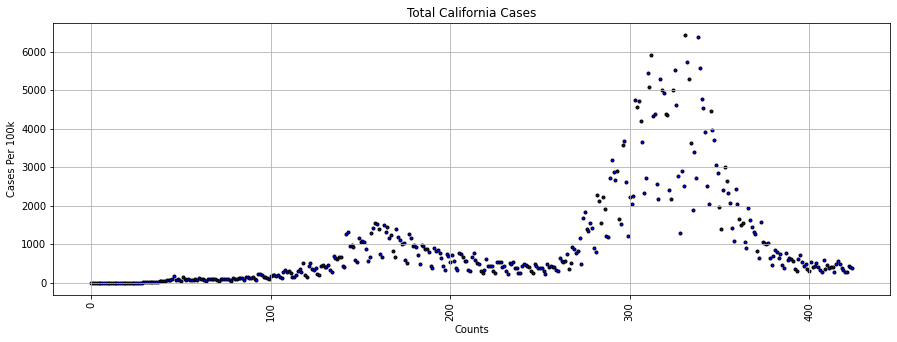

In [9]:
#Scatter Plot California
plt.figure(figsize=(15,5))
x=California_df["Counts"]
y=California_df["Cases Per 100k"]
plt.scatter(x,y, color="blue",marker='.', edgecolors="black")
plt.title("Total California Cases")
#plt.ylim(0, 20)
#plt.xlim(0,450)
plt.xlabel("Counts")
plt.ylabel("Cases Per 100k")
plt.xticks(rotation=90)
plt.grid()
plt.savefig("Figures/Total_California_Cases.png")

In [10]:
# Cases by County:
cases_grouped = clean_case.groupby('county').agg({'cases': 'sum',
                                                  'deaths': 'sum',
                                                  'total_tests': 'sum',
                                                  'positive_tests': 'sum',
                                                  'population': 'max'})

cases_grouped['Cases per 100,000'] = (cases_grouped['cases']/cases_grouped['population']*100000).astype(int)

cases_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Alameda to Yuba
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   cases              58 non-null     float64
 1   deaths             58 non-null     float64
 2   total_tests        58 non-null     float64
 3   positive_tests     58 non-null     float64
 4   population         58 non-null     float64
 5   Cases per 100,000  58 non-null     int32  
dtypes: float64(5), int32(1)
memory usage: 2.9+ KB


In [11]:
# Cases by Date:
cases_by_date=clean_case.groupby(['date'],as_index=False).agg({'cases':sum,
                                            'deaths':sum})

cases_by_date.to_csv('Data/cases_by_date.csv', index=False)
cases_by_date

,date,cases,deaths
0,2020-02-01,0.0,0.0
1,2020-02-02,0.0,0.0
2,2020-02-03,0.0,0.0
3,2020-02-04,0.0,0.0
4,2020-02-05,0.0,0.0
...,...,...,...
420,2021-03-27,1654.0,48.0
421,2021-03-28,1565.0,24.0
422,2021-03-29,2652.0,37.0
423,2021-03-30,2387.0,37.0


In [12]:
# Vaccines by County:
vaccine_grouped = vaccine_df.groupby('county').agg({'total_doses': 'sum',
                                                  'cumulative_fully_vaccinated': 'max'})

vaccine_grouped['Fully Vaccinated per 100,000'] = (vaccine_grouped['cumulative_fully_vaccinated']/
                                                         cases_grouped['population']*100000).astype(int)

vaccine_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Alameda to Yuba
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   total_doses                   58 non-null     int64
 1   cumulative_fully_vaccinated   58 non-null     int64
 2   Fully Vaccinated per 100,000  58 non-null     int32
dtypes: int32(1), int64(2)
memory usage: 1.6+ KB


Both cases_grouped and vaccines_grouped dataframes contain all 58 counties.

In [13]:
grouped_colleges = college_data.groupby('county')['Total_Enrollment'].sum().astype(int)
college_population = grouped_colleges.to_frame()

len(college_population)

41

41 of California's counties contain at least one college with student enrollment for the 2019-2020 school year.

In [14]:
#County Analysis
#https://covidactnow.org/us/california-ca/?s=1780700  
#Per site California has reported 7,014 staffed adult ICU beds
Hosp_Analysis = Hospitalization_Cleaned.groupby(['Date'],as_index=False).agg({'Hospitalized Patients':['sum']})
Hosp_Analysis.columns=Hosp_Analysis.columns.droplevel(1)
Hosp_Analysis.to_csv('Data/Hosp_Analysis.csv', index=False)
Hosp_Analysis

,Date,Hospitalized Patients
0,2020-03-29,0.0
1,2020-03-30,0.0
2,2020-03-31,0.0
3,2020-04-01,0.0
4,2020-04-02,0.0
...,...,...
386,2021-04-19,2148.0
387,2021-04-20,2116.0
388,2021-04-21,2098.0
389,2021-04-22,2095.0


In [15]:
pivoted_hosp_df = Hospitalization_Cleaned.pivot(index='Date', columns='County', values='Hospitalized Patients').fillna(0)
pivoted_hosp_df.to_csv('Data/pivoted_hosp_df.csv', index=False)
display(pivoted_hosp_df)

County,Alameda,Amador,Butte,Calaveras,Colusa,Contra Costa,Del Norte,El Dorado,Fresno,Glenn,...,Sonoma,Stanislaus,Sutter,Tehama,Trinity,Tulare,Tuolumne,Ventura,Yolo,Yuba
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-19,107.0,0.0,11.0,1.0,2.0,53.0,1.0,3.0,105.0,0.0,...,17.0,120.0,0.0,1.0,0.0,27.0,2.0,30.0,2.0,6.0
2021-04-20,102.0,1.0,10.0,1.0,2.0,49.0,1.0,2.0,106.0,0.0,...,13.0,123.0,0.0,1.0,0.0,31.0,1.0,34.0,4.0,9.0
2021-04-21,93.0,1.0,10.0,1.0,2.0,34.0,2.0,3.0,112.0,0.0,...,14.0,116.0,0.0,3.0,0.0,32.0,2.0,24.0,4.0,10.0


#### Running geocodng API to obtain lat/lon values for counties

In [16]:
# Create a list of Counties included in data sets to use for geocoding API

counties = clean_case['county'].unique()

# Creating Lists to fill coordinates
lat = []
lng = []

# Set up for API call
base_url = 'https://maps.googleapis.com/maps/api/geocode/json?address='
    
for county in counties:
    target_county = f'{base_url}{county},+CA&key={gkey}'
    response = requests.get(target_county).json()
    try:
        lat.append(response['results'][0]['geometry']['location']['lat'])
        lng.append(response['results'][0]['geometry']['location']['lng'])
    except:
        print(f'{county} could not be located...Skipping')
        pass
print('Coordinates have been added to datasets.')

Coordinates have been added to datasets.


In [17]:
# Build county DF

county_dict = {'county': counties,
              'latitude': lat,
              'longitude': lng}
county_data = pd.DataFrame(county_dict)

county_data.set_index('county', inplace=True)
county_data['population'] = cases_grouped['population']
county_data['student_pop'] = college_population['Total_Enrollment']
county_data['cases per 100,000'] = cases_grouped['Cases per 100,000']
county_data['Fully Vaccinated per 100,000'] = vaccine_grouped['Fully Vaccinated per 100,000']
county_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, Alameda to Yuba
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   latitude                      58 non-null     float64
 1   longitude                     58 non-null     float64
 2   population                    58 non-null     float64
 3   student_pop                   41 non-null     float64
 4   cases per 100,000             58 non-null     int32  
 5   Fully Vaccinated per 100,000  58 non-null     int32  
dtypes: float64(4), int32(2)
memory usage: 2.7+ KB


In [18]:
county_data['student_pop'] = county_data['student_pop'].fillna(0)
county_data.reset_index(inplace=True)
county_data['% student population'] = round(county_data['student_pop']/county_data['population']*100,2)
county_data['vax_per_case'] = round(county_data['Fully Vaccinated per 100,000']/county_data['cases per 100,000'],2)

county_data.to_csv('Data/county_data.csv', index=False)
county_data.head()

,county,latitude,longitude,population,student_pop,"cases per 100,000","Fully Vaccinated per 100,000",% student population,vax_per_case
0,Alameda,37.779872,-122.282185,1685886.0,130485.0,4995,33949,7.74,6.80
1,Alpine,32.835052,-116.766411,1117.0,0.0,7699,53088,0.00,6.90
2,Amador,38.348892,-120.774093,38531.0,0.0,9311,25405,0.00,2.73
3,Butte,39.625395,-121.537000,217769.0,27274.0,5241,27251,12.52,5.20
4,Calaveras,38.196048,-120.680504,44289.0,0.0,4545,25898,0.00,5.70


### Statistics Analysis

In [19]:
# Finding outlier counties:

print('County Cases Outliers:')
x=county_data['cases per 100,000']
for cases in x:
    lower_bound = (x.quantile(0.25) - (1.5*(x.quantile(0.75) - x.quantile(0.25))))
    upper_bound = (x.quantile(0.75) + (1.5*(x.quantile(0.75) - x.quantile(0.25))))
    if cases < lower_bound or cases > upper_bound:
        outlier = cases
        outlier_county = county_data.loc[x == outlier]
        print('County: ' + outlier_county['county'].item() + ' ' + str(outlier))
    else:
        continue

    
print('\nCounty Vaccines Outliers:')
x=county_data['Fully Vaccinated per 100,000']
for vaccines in x:
    lower_bound = (x.quantile(0.25) - (1.5*(x.quantile(0.75) - x.quantile(0.25))))
    upper_bound = (x.quantile(0.75) + (1.5*(x.quantile(0.75) - x.quantile(0.25))))
    if vaccines < lower_bound or vaccines > upper_bound:
        outlier = vaccines
        outlier_county = county_data.loc[x == outlier]
        print('County: ' + outlier_county['county'].item() + ' ' + str(outlier))
    else:
        continue

County Cases Outliers:
County: Lassen 17026

County Vaccines Outliers:
County: Alpine 53088
County: Marin 46062
County: Mono 46379


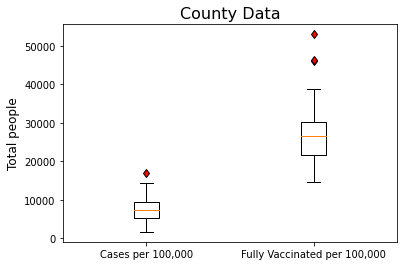

In [20]:
# Generate box plots
labels = ['Cases per 100,000', 'Fully Vaccinated per 100,000']
outliers = dict(markerfacecolor='red', marker='d')
plt.title('County Data', fontsize=16)
plt.ylabel('Total people', fontsize=12)
plt.boxplot([county_data['cases per 100,000'], county_data['Fully Vaccinated per 100,000']], labels=labels, 
            flierprops=outliers)
plt.savefig('Figures/County_outliers')
plt.show()